In [42]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

import apertls
from matplotlib.colors import LogNorm

In [43]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [44]:
env = line.env

# env['adh.11207']=0
# env['adh.11407']=0
# env['adh.11607']=0

# env['mdh.11207'].k0='adh.11207'
# env['mdh.11407'].k0='adh.11407'
# env['mdh.11607'].k0='adh.11607'

line['adh.11207']=0
line['adh.11407']=0
line['adh.11607']=0

line['mdh.11207'].k0='adh.11207'
line['mdh.11407'].k0='adh.11407'
line['mdh.11607'].k0='adh.11607'

In [45]:
#fix of tidp drift for later insertion of collimator
tt = line.get_table()
tw=line.twiss()
s_start_tidp = line.get_s_position('tidp.11434..0')
line.remove(tt.rows['tidp.*'].name)
line.insert(env.place('tidp.11434', at=s_start_tidp), s_tol=1e-6)

Slicing line:   0%|          | 0/75278 [00:00<?, ?it/s]

In [46]:
tw0 = line.twiss()

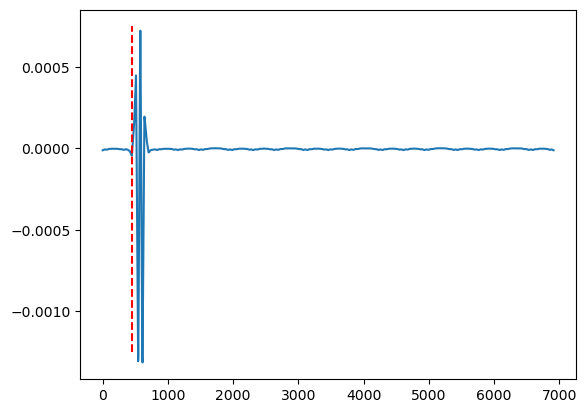

In [47]:
plt.figure()
plt.plot(tw0.s, tw0.x)#bump for the dogleg
plt.vlines(s_start_tidp, -0.00125, 0.00075, color='r', linestyle='--')

In [ ]:
opt = line.match(
    #solve=False, # <--
    method='4d',
    vary=[
        xt.VaryList(['adh.11207', 'adh.11407', 'adh.11607'], step=1e-8, tag='correctors',)
    ],
    targets = [
        xt.TargetSet(x=-30e-3, at='tidp.11434')
        # 
    ],  
    #restore_if_fail=False
    )

                                             
Optimize - start penalty: 0.2998                            


In [41]:
idx_mdh11207 = line.element_names.index('mdh.11207')
idx_mdh11407 = line.element_names.index('mdh.11407')
idx_mdh11607 = line.element_names.index('mdh.11607')
idx_tidp = line.element_names.index('tidp.11434')

tw_before = line.twiss()
opt = line.match(
                start=line.element_names[idx_mdh11207-1],
                end=line.element_names[idx_mdh11207+1],
                init=tw_before.get_twiss_init(at_element=line.element_names[idx_mdh11207-1]),
                vary=[
                    xt.Vary(name='adh.11207', step=1e-10),
                    xt.Vary(name='adh.11407', step=1e-10),
                    xt.Vary(name='adh.11607', step=1e-10),
                ],
                targets=[
                    # I want the vertical orbit to be at 3 mm at mq.28l8.b1 with zero angle
                    xt.Target('x', at='tidp.11434', value=-6.5e-3, tol=1e-4, scale=1),
                    xt.Target('px', at='tidp.11434', value=0, tol=1e-6, scale=1000),
                    # I want the bump to be closed
                    xt.Target('x', at=line.element_names[idx_tidp+4], value=tw_before['x', line.element_names[idx_tidp+4]],
                            tol=1e-6, scale=1),
                    xt.Target('px', at=line.element_names[idx_tidp+4], value=tw_before['px', line.element_names[idx_tidp+4]],
                            tol=1e-7, scale=1000),
                ],
                #restore_if_fail=False
            )

KeyError: "Cannot find 'tidp.11434' in column 'name'"